# ⚠️⚠️⚠️⚠️⚠️ ***Attention*** ⚠️⚠️⚠️⚠️⚠️

Please specify your assigned GPU number.

In [3]:
GPU_NUM = 5 

# 0. Import essential libraries and evironment setting 

In [6]:
cd

/home/jupyter-ria


/opt/tljh/user/envs/torch-tf-keras/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/opt/tljh/user/envs/torch-tf-keras/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
cd /home/jupyter-ria

/home/jupyter-ria


/opt/tljh/user/envs/torch-tf-keras/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
conda activate Datathon24


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_NUM)
import keras

In [11]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


2024-08-20 14:35:58.655968: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor
import itertools
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from keras.preprocessing import image 
from keras.layers import Rescaling
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import image_dataset_from_directory

# 1. Design your CXR model for Pneumothorax identification

<img src="files/CXR model.png" alt="Drawing"/>

## 1.1. Set input size and load pre-trained model
<li>Pre-Trained Model:
A model that has already been trained on a large and general dataset (e.g., ImageNet for image classification, Wikipedia text for NLP tasks).
<li>Advantages of Using a Pre-Trained Model:Reduced Training Time, Better Performance

Other popular options:
InceptionV3, Xception, VGG16, VGG19, EfficientNet, DenseNet121/169/201, MobileNetV2/V3, NASNet, ResNeXt, SqueezeNet, AlexNet...

See here: https://keras.io/api/applications/

##### ⭐ Different models have varying numbers of <b>parameters</b>, which are what we intend to "train" (what deep learning algorithms aim to "learn")!

In [27]:
from keras.applications import ResNet50

# Define the input size
input_shape = (224, 224, 3)
# Load ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

In [18]:
######TryIt: Another pretrained model######
from keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<img src="files/step1.png" alt="Drawing" style="height: 400px;"/>

## 1.2. Connect pretrained model and your own output 

In [28]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)

<img src="files/step2.png" alt="Drawing" style="height: 400px;"/>

In [29]:
num_classes = 1
output = Dense(num_classes, activation='sigmoid')(x)

<img src="files/step3.png" alt="Drawing" style="height: 400px;"/>

In [30]:
model = Model(inputs=base_model.input, outputs=output)

<img src="files/step4.png" alt="Drawing" style="height: 400px;"/>

## 1.3. Take a look at your model

In [31]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 1.4. Compile the Model
To configure the model for training. It sets up the model with key components needed for the training process, including the loss function, optimizer, and evaluation metrics.

In [33]:
# Define Binary Cross Entropy (BCE) loss

BCE = keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.1,
)

<li>When from_logits=False (as in this case), the predictions are expected to be probabilities (i.e., values between 0 and 1). The model output should already be passed through a sigmoid activation function before computing the loss.
<li>label_smoothing=0.1
This technique smooths the labels by assigning a small portion of the label's confidence to the other class. For example, if the true label is 1, instead of using [1, 0], the label is smoothed to [0.9, 0.1].
Purpose: Helps to regularize the model, making it less confident in its predictions, which can improve generalization, especially in cases with noisy labels.

In [39]:
# Compile the model
model.compile(loss=BCE,
              optimizer=Adam(learning_rate=0.00001),
              metrics=['accuracy'])

### 1.3.1. Loss 
💡Just like how teachers grade students, we need to provide the model a function in which to grade its answers. This is called a `loss function`. 

We will use a type of loss function called Cross Entropy which is designed to grade if a model predicted the correct category from a group of categories.
This is the loss function for binary classification problems. The answer is $y_{target}$ and the prediction is $y_{predict}$:

$$ BCE = -{(y_{target}\log(y_{predict}) + (1 - y_{target})\log(1 - y_{predict}))}$$

$$ L = -\sum_{i=1}^Ny_{target}^{i}\log(y_{predict}^{i})$$

<img src="files/crossentropy.png" alt="Drawing" style="height: 300px;"/>

#### To visualize:
<img src="files/BCE.gif" alt="Drawing" style="height: 400px;"/>
<a href="https://www.desmos.com/calculator/zytm2sf56e">Source</a>

##### Red: Answer $p\left(x\right)$
##### Green: Prediciton $q\left(x\right)$ 
##### Blue: $-p\left(x\right)\log_{e}\left(\left(q\left(x\right)\right)\right)$
##### Purple: Cross entropy

❗❗If your problem involves more than two classes, you would need to use 'categorical_crossentropy' instead. ❗❗Multiclass vs multilabel classification.

### 1.3.2. Optimizer and learning rate
<li>The optimizer tells the model how to change its internal settings (parameters) to improve its predictions. It does this by trying to make the loss function as small as possible.

💡 Imagine you're trying to find the lowest point in a valley while blindfolded. You can only feel the ground around you to decide which direction to move. The optimizer is like a guide who tells you, "Move a little to the left," or "Step forward," based on the slope of the ground. Following these directions, you gradually make your way to the lowest point in the valley, which is like finding the best model settings to make the most accurate predictions.

<img src="files/adam.gif" alt="Drawing" style="height: 400px;"/>

Source: https://medium.com/@sedatparlak1953/foundation-of-neural-networks-a68925aa7e2

⭐ Adam is a widely used optimizer that adapts learning rates for each parameter. It usually works well, especially for complex models or when dealing with noisy gradients. 

<li>The learning rate can be thought of as the size of the steps you take as you follow the guide's instructions. If your learning rate is low, it’s like taking very small steps. This means you move slowly and carefully down the slope of the valley. If your learning rate is high, it’s like taking big, quick steps. You might overshoot the lowest point or miss it entirely, bouncing around instead of settling down.
    

⭐ 0.00001 is a low learning rate. It can help achieve more stable convergence, but it might make training slow. If your model is not learning well, you may want to try a slightly higher learning rate (e.g., 0.0001 or 0.00005) or use learning rate scheduling.

<img src="files/lr1.png" alt="Drawing" style="height: 80%;"/>

### 1.3.3. Metrics
How you eveluate your model during training? Accuracy seems to be a straightforward metric for classification tasks. <br>
<img src="files/nobita.png" alt="Drawing" style="height: 150px;"/>
#### ❗❗However, if your classes are imbalanced, you might want to add additional metrics such as Precision, Recall, or AUC to better evaluate your model’s performance.

In [40]:
#####TryIt######
model.compile(loss=BCE, optimizer=Adam(learning_rate=0.001), metrics=['auc'])

# 2. Get ready for model training 
Now that we have prepared training and validation data, and a model, it's time to train our model with our training data, and verify it with its validation data.

"Training a model with data" is often also called "fitting a model to data." Put another way, it highlights that the shape of the model changes over time to more accurately understand the data that it is being given. Again, the "shape of the model" is determined by "parameters."

## 2.1. Batch size and epochs

In [41]:
batch_size = 16
epochs = 200

<img src="files/batch_epoch.png" alt="Drawing" style="height: 400px;"/>
Ref: https://www.javatpoint.com/epoch-in-machine-learning

### 2.1.1. Batch Size
The batch_size is the number of training samples the model processes before updating its internal parameters (weights). During training, the dataset is typically too large to be processed all at once, so it's divided into smaller batches. The model's weights are updated after each batch, rather than after seeing the entire dataset.

💡Imagine you’re baking cookies, the batch size is like the number of cookies you decide to bake at once.

#### ⭐ Effect:
⬇️ Batch Size
Leads to more frequent updates but it also means more noise in the gradient estimation.
Can generalize better but might take longer to converge.
More suitable for models with limited memory (e.g., on GPUs with less memory). <br/>
⬆️ Batch Size:
Leads to less frequent updates but with a more accurate estimate of the gradient.
Can make training faster but might result in overfitting.
Requires more memory, as more data is processed at once.

### 2.1.2 Epochs
An epoch is one complete pass through the entire training dataset. During training, the model usually goes through multiple epochs to learn from the data. After each epoch, the model has seen all samples in the training dataset once, and its parameters have been updated accordingly.
#### ⭐ Effect:
⬇️  Epochs:
May result in underfitting, where the model hasn't learned enough from the data.
In practice, you may need to experiment with different batch_size and epochs values to find the optimal combination for your specific problem and dataset.<br/>

⬆️ Epochs:
Allows the model to learn more from the data, which can improve accuracy. However, after a certain point, it may lead to overfitting, where the model performs well on training data but poorly on unseen data.

In [21]:
#####TryIt######
#batch_size = 4
#epochs = 10

## 2.2. Prepare data

### 2.2.1. Load training and validation datasets

<img src="files/training-data-validation-test.png" alt="Drawing" style="height: 500px;"/>

Ref: https://www.v7labs.com/blog/train-validation-test-set

In [42]:
#TRAIN_FOLDER = '/home/fli40/Data/Datathon24_SummerSchool_CXR/Data1_Preprocessed/train/'
#VAL_FOLDER = '/home/fli40/Data/Datathon24_SummerSchool_CXR/Data1_Preprocessed/validation/'

TRAIN_FOLDER = '/fsx/embed/summer-school-24/Datathon24_SummerSchool_CXR/Data1_Preprocessed/train/'
VAL_FOLDER = '/fsx/embed/summer-school-24/Datathon24_SummerSchool_CXR/Data1_Preprocessed/validation/'

train_ds = image_dataset_from_directory(
    TRAIN_FOLDER,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

val_ds = image_dataset_from_directory(
    VAL_FOLDER,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 1354 files belonging to 2 classes.
Found 451 files belonging to 2 classes.


#### ⭐ Why we need validation data?

<img src="files/train_valid.png" alt="Drawing" style="height: 500px;"/>

Source: https://stackoverflow.com/questions/46561531/why-does-the-validation-performance-have-large-fluctuations-during-deep-cnn-trai

#### ⭐ Why we need validation data?
Reasons:
<li> Model evaluation during training </li>
<li> Hyperparameter tuning</li>
<li> Model selection/early stop</li>

#### ⭐ Why not just use testing data?

Reasons: Overfitting to Test Data, evaluation is biased!

### 2.2.2. Show a batch of training data 

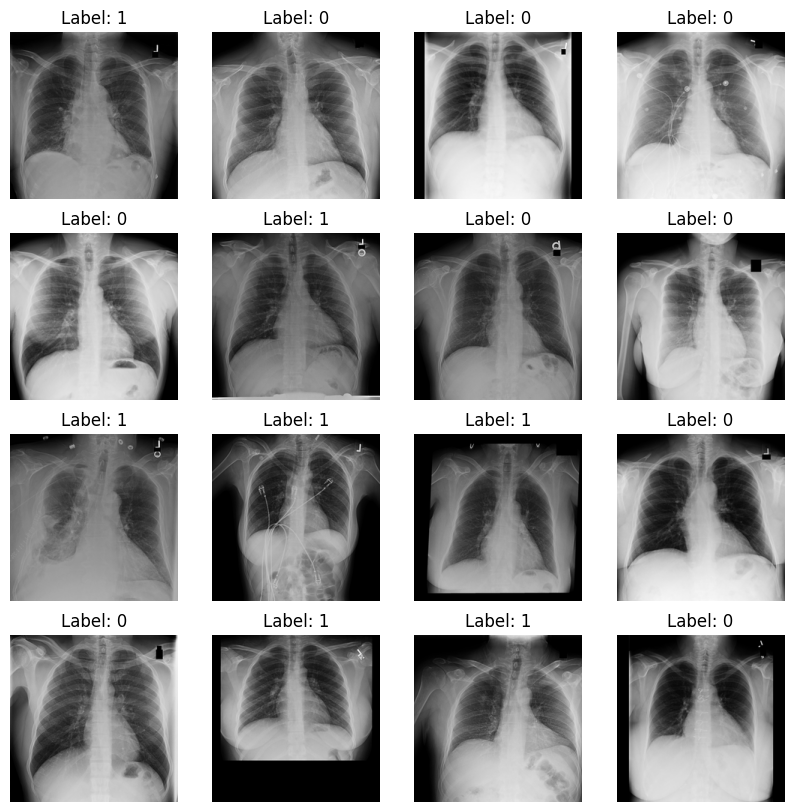

2024-08-20 15:36:53.350529: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
for images, labels in train_ds.take(1):
    # Convert to numpy for easier manipulation
    images = images.numpy()
    labels = labels.numpy()
    # Plot the images in the batch
    plt.figure(figsize=(10, 10))
    
    for i in range(min(len(images), batch_size)):  
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

### 2.2.3. Normalization
Rescaling helps normalize the pixel values, bringing them into a range that is easier for neural networks to work with.

In [45]:
# Add rescaling
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

#### ⭐ Are we ready to train a model?

In [ ]:
# Of course we can train a model
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds)

Epoch 1/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 69s 500ms/step - auc: 0.5815 - loss: 1.0454 - val_auc: 0.5000 - val_loss: 5.0739
Epoch 2/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 474ms/step - auc: 0.7240 - loss: 0.6345 - val_auc: 0.5000 - val_loss: 0.6970
Epoch 3/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 474ms/step - auc: 0.7647 - loss: 0.6062 - val_auc: 0.5000 - val_loss: 0.6988
Epoch 4/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 482ms/step - auc: 0.8017 - loss: 0.5749 - val_auc: 0.5000 - val_loss: 0.8703
Epoch 5/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 480ms/step - auc: 0.8031 - loss: 0.5679 - val_auc: 0.6037 - val_loss: 0.9365
Epoch 6/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 479ms/step - auc: 0.7874 - loss: 0.5779 - val_auc: 0.5000 - val_loss: 0.6938
Epoch 7/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 482ms/step - auc: 0.8128 - loss: 0.5702 - val_auc: 0.5000 - val_loss: 0.7051
Epoch 8/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 481ms/step - auc: 0.8495 - loss: 0.5365 - val_auc: 0.5000 - val_loss: 1.1670
Epoch 9/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 4

#### ⭐ What is missing? 

## 2.3. Keep track of your training process and prevent overfitting

### 2.3.1. Save checkpoint

In [1]:
# Callbacks

model_checkpoint = ModelCheckpoint(
    filepath='./weights/best_model_Data1.keras', 
    monitor='val_loss', 
    save_best_only=True
)

NameError: name 'ModelCheckpoint' is not defined

ModelCheckpoint saves copies of the model at specific moments during training. For example, if the model achieves its lowest error rate (best performance) on a validation set, ModelCheckpoint will save the model at that point.

💡 Imagine you’re writing a long document. As you write, you might hit "save" whenever you make significant progress or reach an important point. This way, if your computer crashes, you don't lose all your work; you can start again from the last saved version. Also, if you make changes later that you don’t like, you can go back to a previous version where the document was better.

<li> filepath: Specifies the file path where the model will be saved.
<li> monitor: Determines which metric to monitor to decide when to save the model.
<li> save_best_only: Controls whether the model is saved only when there is an improvement.

### 2.3.2. Early stop

In [2]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, restore_best_weights=True, verbose=1)


# earlystopping= tf.keras.callbacks.EarlyStopping(
#     monitor= 'val_loss',
#     min_delta=0,
#     patience=0,
#     verbose=0,
#     mode= 'auto',
#     baseline=None,
#     restore_best_weights=True,
#     start_from_epoch=0
# )

NameError: name 'EarlyStopping' is not defined

💡 Imagine you’re baking cookies. You check them regularly, and when they’re perfectly golden, you take them out, even if the timer says they need a few more minutes. This prevents them from burning.

<li>min_delta=0.0001: This is the minimum change in the monitored quantity (validation loss) that qualifies as an improvement. If the change in val_loss is less than 0.0001, it's considered insignificant.

<li>patience=20: The training process will stop if there is no improvement in the validation loss for 20 consecutive epochs. The model will be given 20 epochs to improve before stopping.

<li>restore_best_weights=True: When training stops, the model weights are reverted to the best weights observed during the training. This ensures that the best-performing model is saved, not the model at the final epoch.

<li>verbose=1: This enables the display of messages when the early stopping criterion is met, providing feedback during training.

### 2.3.3. Reducing learning rate

In [28]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    min_lr=1e-7,
    min_delta=0.0001
)

<img src="files/lr2.png" alt="Drawing" style="height: 60%;"/>

💡 Imagine painting a picture. In the beginning, you use broad, quick brushstrokes to cover the canvas. But as you get closer to finishing, you switch to smaller, slower strokes to add fine details and avoid mistakes. 

<li>factor=0.2: When the learning rate is reduced, it will be multiplied by this factor. In this case, the learning rate will be reduced to 20% of its current value.

<li>patience=10: The learning rate will be reduced if there is no improvement in validation loss for 10 consecutive epochs.

<li>min_lr=1e-7: This sets the lower bound for the learning rate. The learning rate will not be reduced below this value, ensuring it doesn't become too small, which could hinder training.

<li>min_delta=0.0001: This is the same as in EarlyStopping, specifying the minimum change in validation loss to consider it as an improvement.

In [30]:
# Create a custom callback to update the plot
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
        
    def on_epoch_end(self, epoch, logs={}):
        # Store metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Clear the output and redraw the plot
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
        plt.plot(self.metrics['loss'], label='Training Loss')
        if 'val_loss' in self.metrics:
            plt.plot(self.metrics['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## 2.4 Let's train your model!

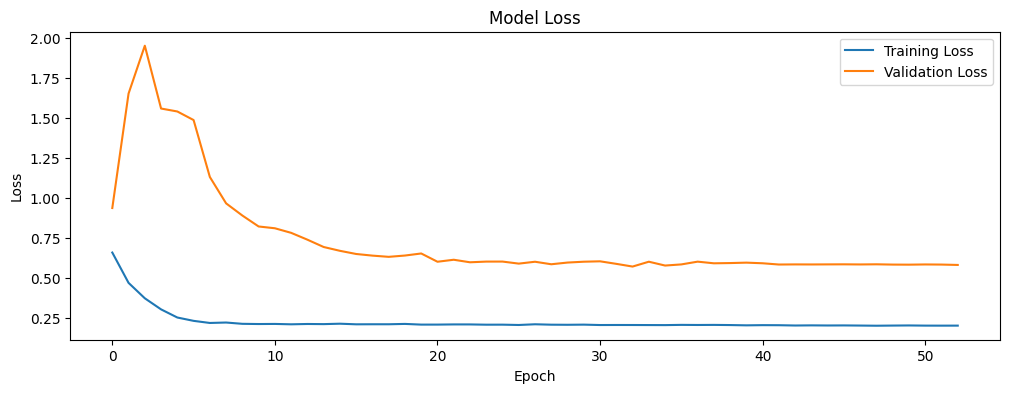

85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 463ms/step - accuracy: 1.0000 - loss: 0.2038 - val_accuracy: 0.7317 - val_loss: 0.5827 - learning_rate: 2.0000e-06
Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 33.


In [31]:
# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[PlotLearning(), model_checkpoint, early_stopping, reduce_lr])

#### ⭐ Question: How do we obtain the number "85" in the training details above?

# Recap

<li>Parameters are what we intend to "train" (what deep learning algorithms aim to "learn")!
<li>Leverage pre-trained models (e.g., ResNet) to benefit from their learned features.
<li>Select an appropriate learning rate and loss function tailored to your specific task.
<li>Determine the batch size and number of epochs for training your model.
<li>Monitor the model training process to ensure effective learning and convergence.